In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =6.375563e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.55 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/trp75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

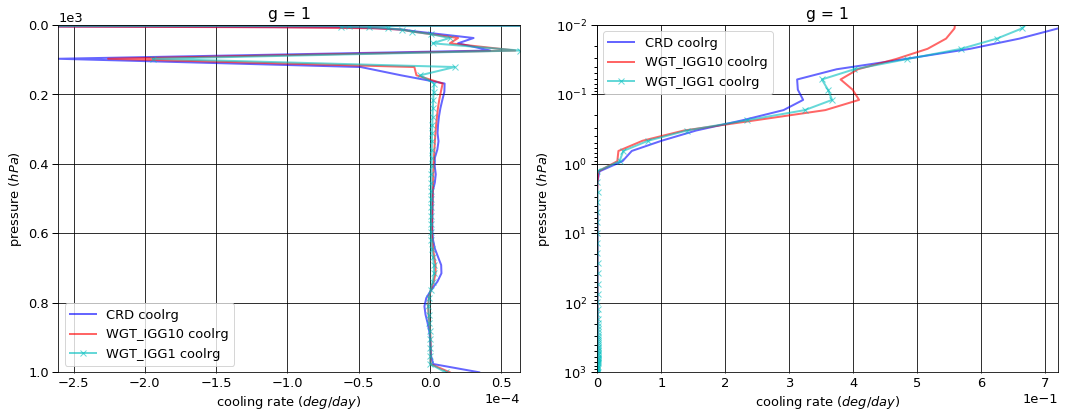

# Figure: cooling rate g-group 2

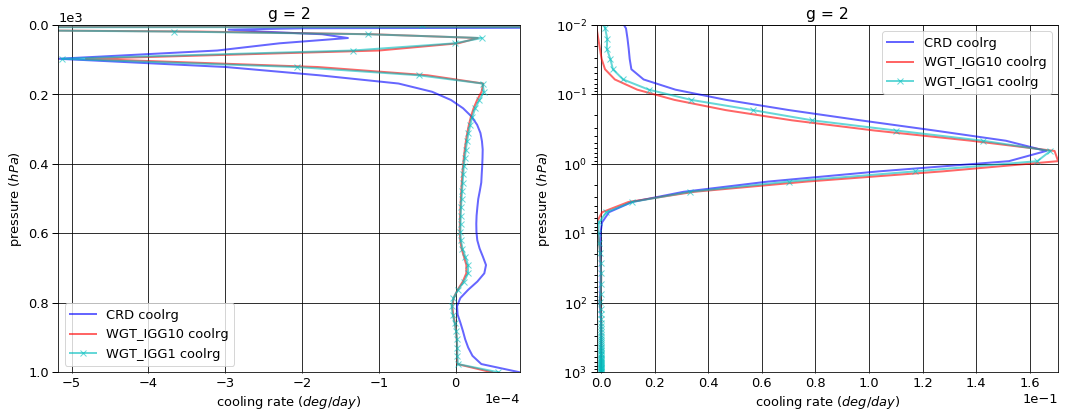

# Figure: cooling rate g-group 3

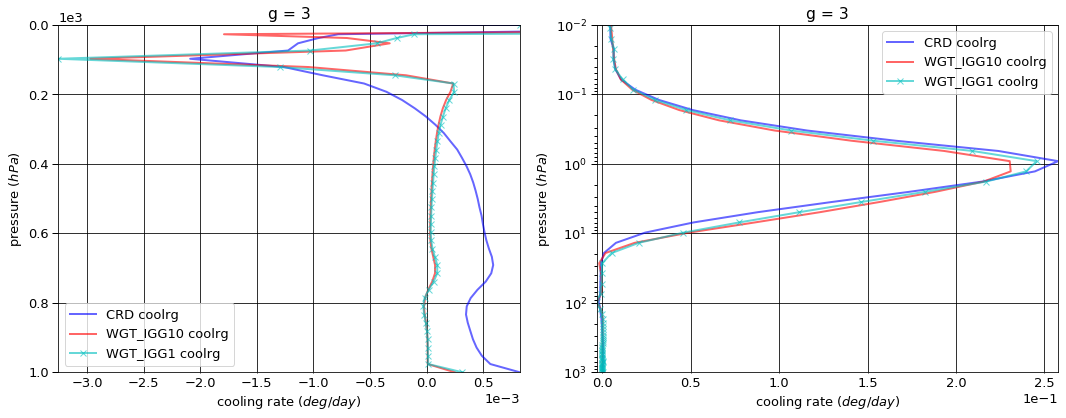

# Figure: cooling rate g-group 4

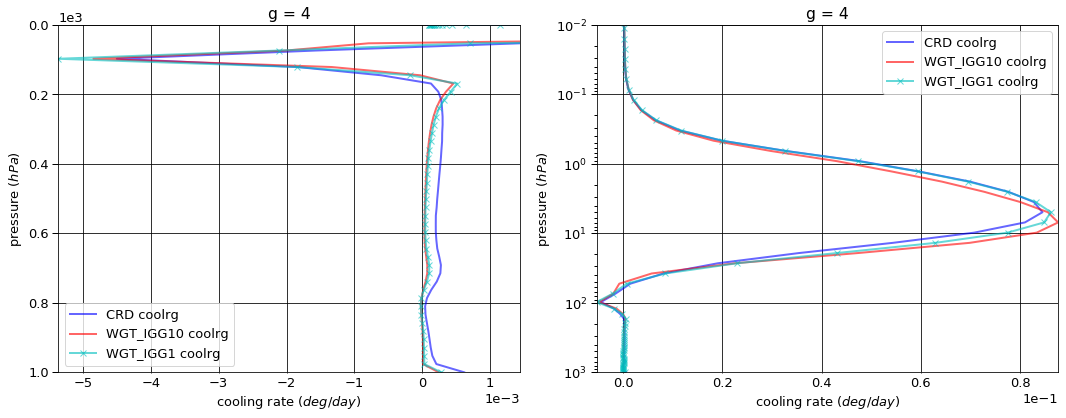

# Figure: cooling rate g-group 5

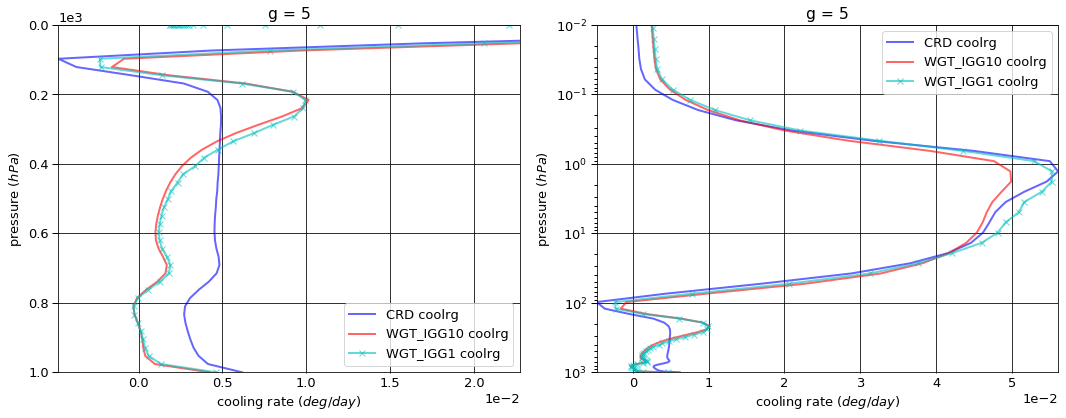

# Figure: cooling rate g-group 6

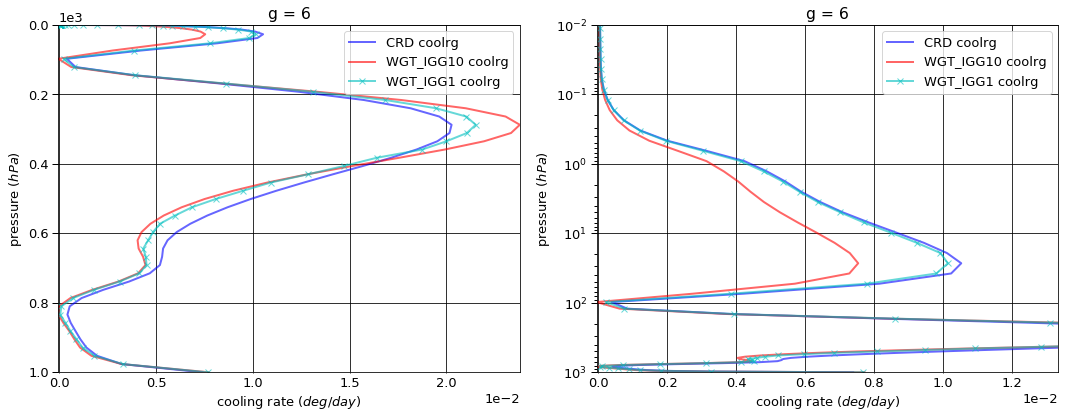

# Figure: cooling rate g-group 7

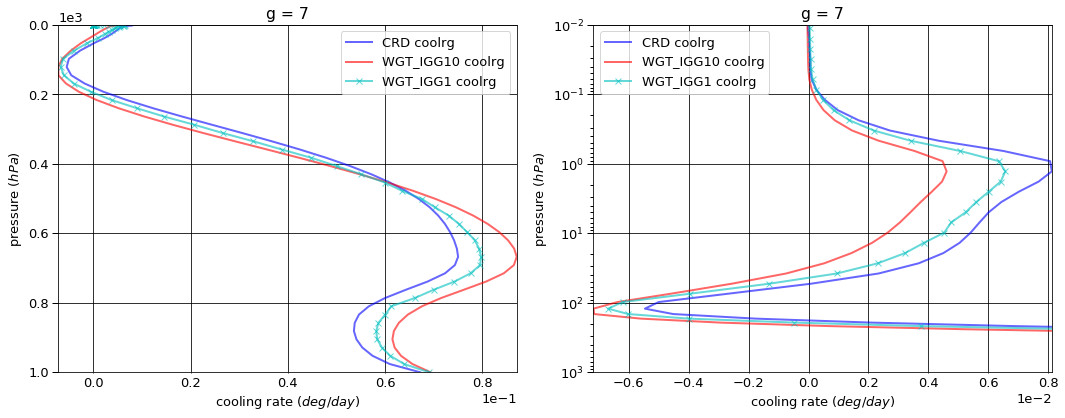

# Figure: cooling rate g-group 8

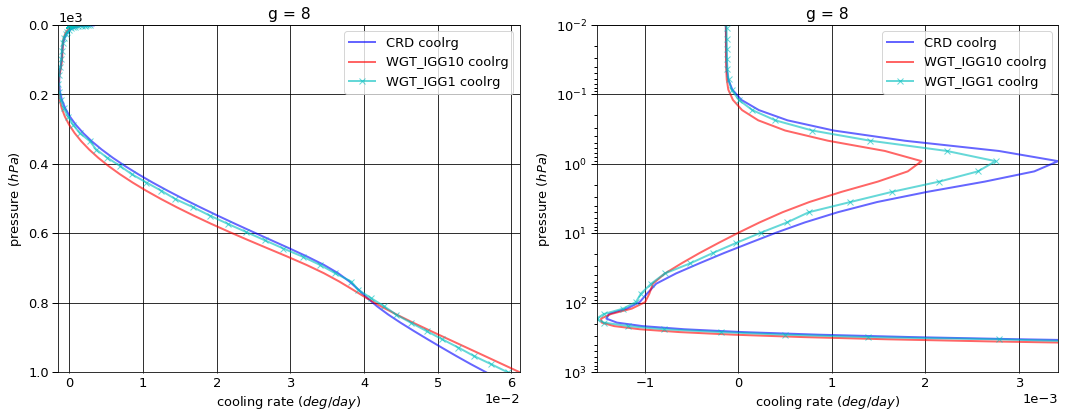

# Figure: cooling rate g-group 9

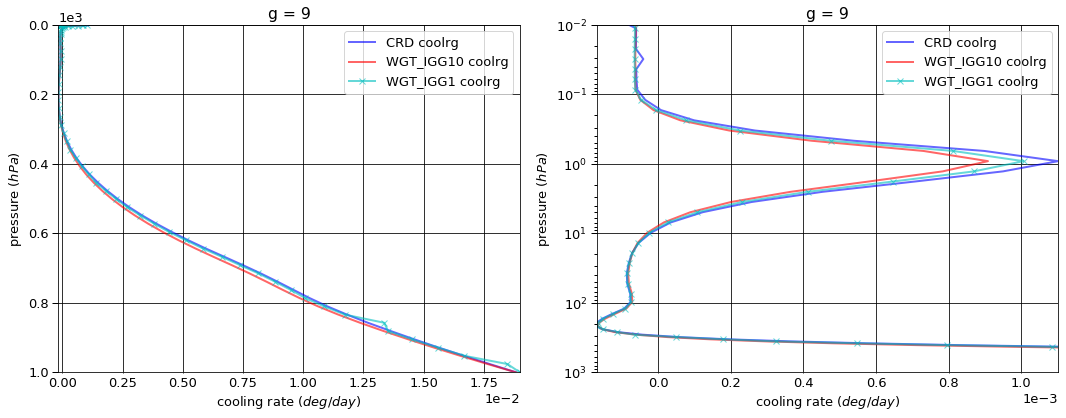

# Figure: cooling rate g-group total

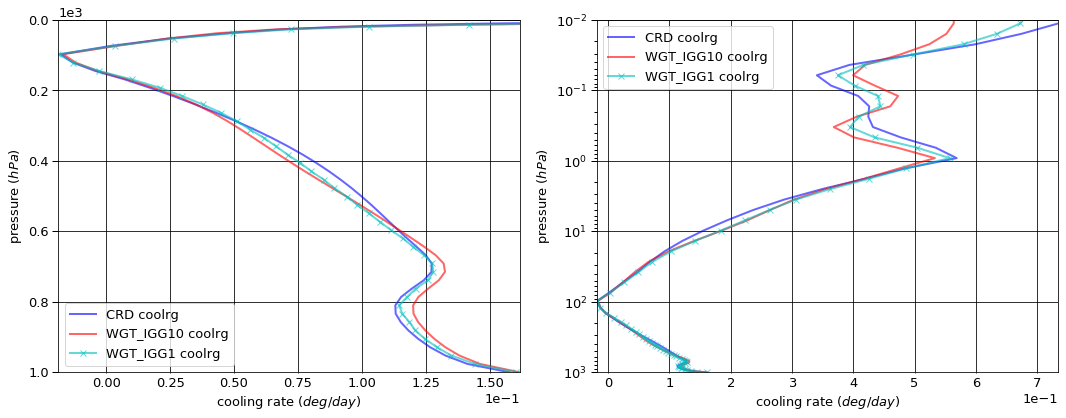

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.017177  0.000000  -0.017177
  1013.0   76     -0.043303  0.043200  -0.000103
2 0.0      1      -0.028853  0.000000  -0.028853
  1013.0   76     -0.048119  0.047631  -0.000488
3 0.0      1      -0.160128  0.000000  -0.160128
  1013.0   76     -0.298479  0.282887  -0.015592
4 0.0      1      -0.191785  0.000000  -0.191785
  1013.0   76     -0.471588  0.467393  -0.004195
5 0.0      1      -0.792915  0.000000  -0.792915
  1013.0   76     -1.884954  1.748496  -0.136457
6 0.0      1      -1.010171  0.000000  -1.010171
  1013.0   76     -2.578258  2.542869  -0.035388
7 0.0      1      -6.681202  0.000000  -6.681202
  1013.0   76    -10.229967  8.828880  -1.401087
8 0.0      1      -7.916779  0.000000  -7.916779
  1013.0   76     -8.728974  3.252823  -5.476152
9 0.0      1     -14.071540  0.000000 -14.071540
  1013.0   76    -14.208093  0.748120 -13.459973


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.016585  0.000000  -0.016585
  1013.0   76     -0.043303  0.043264  -0.000039
2 0.0      1      -0.029925  0.000000  -0.029925
  1013.0   76     -0.048119  0.047986  -0.000132
3 0.0      1      -0.154537  0.000000  -0.154537
  1013.0   76     -0.298479  0.297780  -0.000699
4 0.0      1      -0.193415  0.000000  -0.193415
  1013.0   76     -0.471588  0.470919  -0.000669
5 0.0      1      -0.567611  0.000000  -0.567611
  1013.0   76     -1.884954  1.870630  -0.014324
6 0.0      1      -0.966618  0.000000  -0.966618
  1013.0   76     -2.578258  2.545272  -0.032986
7 0.0      1      -6.740953  0.000000  -6.740953
  1013.0   76    -10.229967  9.073144  -1.156823
8 0.0      1      -8.012015  0.000000  -8.012015
  1013.0   76     -8.728974  3.083441  -5.645533
9 0.0      1     -14.081863  0.000000 -14.081863
  1013.0   76    -14.208093  0.715153 -13.492939


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.016670  0.000000  -0.016670
  1013.0   76     -0.043303  0.043273  -0.000030
2 0.0      1      -0.029515  0.000000  -0.029515
  1013.0   76     -0.048119  0.047961  -0.000157
3 0.0      1      -0.153362  0.000000  -0.153362
  1013.0   76     -0.298479  0.297587  -0.000892
4 0.0      1      -0.191641  0.000000  -0.191641
  1013.0   76     -0.471588  0.470852  -0.000736
5 0.0      1      -0.587303  0.000000  -0.587303
  1013.0   76     -1.884954  1.867821  -0.017133
6 0.0      1      -0.966423  0.000000  -0.966423
  1013.0   76     -2.578258  2.543728  -0.034530
7 0.0      1      -6.658169  0.000000  -6.658169
  1013.0   76    -10.229967  8.962690  -1.267277
8 0.0      1      -7.936907  0.000000  -7.936907
  1013.0   76     -8.728974  3.239924  -5.489050
9 0.0      1     -14.075251  0.000000 -14.075251
  1013.0   76    -14.208093  0.742751 -13.465341


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000592  0.000000  0.000592
  1013.0   76     0.000000  0.000064  0.000064
2 0.0      1     -0.001072  0.000000 -0.001072
  1013.0   76     0.000000  0.000355  0.000355
3 0.0      1      0.005591  0.000000  0.005591
  1013.0   76     0.000000  0.014893  0.014893
4 0.0      1     -0.001629  0.000000 -0.001629
  1013.0   76     0.000000  0.003526  0.003526
5 0.0      1      0.225304  0.000000  0.225304
  1013.0   76     0.000000  0.122134  0.122133
6 0.0      1      0.043553  0.000000  0.043553
  1013.0   76     0.000000  0.002403  0.002403
7 0.0      1     -0.059751  0.000000 -0.059751
  1013.0   76     0.000000  0.244264  0.244264
8 0.0      1     -0.095236  0.000000 -0.095236
  1013.0   76     0.000000 -0.169382 -0.169382
9 0.0      1     -0.010323  0.000000 -0.010323
  1013.0   76     0.000000 -0.032967 -0.032966


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000506  0.000000  0.000506
  1013.0   76     0.000000  0.000073  0.000073
2 0.0      1     -0.000662  0.000000 -0.000662
  1013.0   76     0.000000  0.000330  0.000330
3 0.0      1      0.006766  0.000000  0.006766
  1013.0   76     0.000000  0.014700  0.014700
4 0.0      1      0.000144  0.000000  0.000144
  1013.0   76     0.000000  0.003459  0.003459
5 0.0      1      0.205612  0.000000  0.205612
  1013.0   76     0.000000  0.119325  0.119325
6 0.0      1      0.043748  0.000000  0.043748
  1013.0   76     0.000000  0.000859  0.000859
7 0.0      1      0.023033  0.000000  0.023033
  1013.0   76     0.000000  0.133810  0.133810
8 0.0      1     -0.020128  0.000000 -0.020128
  1013.0   76     0.000000 -0.012898 -0.012898
9 0.0      1     -0.003711  0.000000 -0.003711
  1013.0   76     0.000000 -0.005369 -0.005368

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.738160
  1001.112500 75     0.000035
2 0.000312    1      0.002492
  1001.112500 75     0.000084
3 0.000312    1      0.000813
  1001.112500 75     0.000825
4 0.000312    1      0.000075
  1001.112500 75     0.000617
5 0.000312    1     -0.000126
  1001.112500 75     0.006179
6 0.000312    1      0.000037
  1001.112500 75     0.007399
7 0.000312    1     -0.000054
  1001.112500 75     0.067218
8 0.000312    1     -0.000142
  1001.112500 75     0.056569
9 0.000312    1     -0.000057
  1001.112500 75     0.018842


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.444201
  1001.112500 75     0.000014
2 0.000312    1     -0.006388
  1001.112500 75     0.000047
3 0.000312    1      0.001791
  1001.112500 75     0.000251
4 0.000312    1      0.000107
  1001.112500 75     0.000241
5 0.000312    1      0.001791
  1001.112500 75     0.004241
6 0.000312    1      0.000026
  1001.112500 75     0.007732
7 0.000312    1     -0.000068
  1001.112500 75     0.069337
8 0.000312    1     -0.000132
  1001.112500 75     0.061142
9 0.000312    1     -0.000056
  1001.112500 75     0.018832


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.616714
  1001.112500 75     0.000011
2 0.000312    1     -0.004538
  1001.112500 75     0.000056
3 0.000312    1      0.000829
  1001.112500 75     0.000317
4 0.000312    1      0.000098
  1001.112500 75     0.000277
5 0.000312    1      0.001846
  1001.112500 75     0.004614
6 0.000312    1      0.000038
  1001.112500 75     0.007678
7 0.000312    1     -0.000017
  1001.112500 75     0.069058
8 0.000312    1     -0.000131
  1001.112500 75     0.059503
9 0.000312    1     -0.000059
  1001.112500 75     0.019001


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.939589e-01
  1001.112500 75    -2.062851e-05
2 0.000312    1     -8.880159e-03
  1001.112500 75    -3.631145e-05
3 0.000312    1      9.774850e-04
  1001.112500 75    -5.737425e-04
4 0.000312    1      3.240032e-05
  1001.112500 75    -3.761845e-04
5 0.000312    1      1.916865e-03
  1001.112500 75    -1.937849e-03
6 0.000312    1     -1.091599e-05
  1001.112500 75     3.325819e-04
7 0.000312    1     -1.421154e-05
  1001.112500 75     2.119340e-03
8 0.000312    1      1.046423e-05
  1001.112500 75     4.572473e-03
9 0.000312    1      2.217910e-07
  1001.112500 75    -9.219000e-06


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.214460e-01
  1001.112500 75    -2.361690e-05
2 0.000312    1     -7.030897e-03
  1001.112500 75    -2.793419e-05
3 0.000312    1      1.543147e-05
  1001.112500 75    -5.074614e-04
4 0.000312    1      2.282544e-05
  1001.112500 75    -3.403069e-04
5 0.000312    1      1.972051e-03
  1001.112500 75    -1.564863e-03
6 0.000312    1      9.615650e-07
  1001.112500 75     2.785982e-04
7 0.000312    1      3.672676e-05
  1001.112500 75     1.840816e-03
8 0.000312    1      1.061101e-05
  1001.112500 75     2.934058e-03
9 0.000312    1     -1.952093e-06
  1001.112500 75     1.590550e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.870550,0.000000,-30.870550
1013.0,76,-38.491734,17.962299,-20.529435



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.763522,0.00000,-30.763522
1013.0,76,-38.491734,18.14759,-20.344144



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.615242,0.000000,-30.615242
1013.0,76,-38.491734,18.216587,-20.275147



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.107028,0.000000,0.107028
1013.0,76,0.000000,0.185291,0.185291



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.255308,0.000000,0.255308
1013.0,76,0.000000,0.254288,0.254289


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.741199
1001.112500,75,0.157767



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.441272
1001.112500,75,0.161838



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.614779
1001.112500,75,0.160516



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.299927
1001.112500,75,0.004070



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.126420
1001.112500,75,0.002748


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001125,0.001094
2,0.001250,0.001218
3,0.007750,0.007589
4,0.012250,0.011931
5,0.048938,0.048008
6,0.066937,0.065427
7,0.265437,0.261001
8,0.226562,0.227542
9,0.369750,0.376189


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.213044e-19
2,2.053870e-20
3,1.906144e-21
4,1.715202e-21
5,1.602800e-22
6,6.938182e-22
7,6.651099e-23
8,6.375895e-24
9,1.011442e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.213044e-19,NaN,0.001125,0.001094,0.001125,0.001094,1.0
2,2.053870e-20,0.092807,0.001250,0.001218,0.002375,0.002312,1.0
3,1.906144e-21,0.092807,0.007750,0.007589,0.010125,0.009900,1.0
4,1.715202e-21,0.899828,0.012250,0.011931,0.022375,0.021832,10.0
5,1.602800e-22,0.093447,0.048938,0.048008,0.071313,0.069840,10.0
6,6.938182e-22,4.328789,0.066937,0.065427,0.138250,0.135267,500.0
7,6.651099e-23,0.095862,0.265437,0.261001,0.403687,0.396268,500.0
8,6.375895e-24,0.095862,0.226562,0.227542,0.630250,0.623811,500.0
9,1.011442e-25,0.015864,0.369750,0.376189,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     6.103954e-19  3.857386e-19   1.582407  2.874350e-03
      2 0.000312     2.217231e-20  1.387076e-20   1.598493  8.660777e-05
      3 0.000312     1.466569e-21  8.070023e-22   1.817305  6.715831e-06
      4 0.000312     1.329693e-23  1.214359e-23   1.094975  6.855546e-08
      5 0.000312     3.796044e-23  1.666682e-23   2.277605  1.558559e-07
      6 0.000312     5.073425e-25  4.955462e-25   1.023805  2.648141e-09
      7 0.000312     7.333749e-25  4.939187e-25   1.484809  3.248326e-09
      8 0.000312     4.690370e-25  1.184822e-25   3.958714  2.111707e-09
      9 0.000312     8.228222e-26  4.154248e-27  19.806767  4.148807e-10
2     1 0.000750     6.137586e-19  3.876631e-19   1.583227  1.164001e-03
      2 0.000750     2.234910e-20  1.396387e-20   1.600494  3.513651e-05
      3 0.000750     1.479416e-21  8.129156e-22   1.819889  2.728004e-06
      4 0.000750     1.357913e-23  1.240500e-23   1.094650  2.820163e-08
      5 0.000750     3.827904e-23  1.676919e-23   2.282701  6.327155e-08
      6 0.000750     5.135468e-25  5.015762e-25   1.023866  1.079641e-09
      7 0.000750     7.407589e-25  4.982272e-25   1.486789  1.320848e-09
      8 0.000750     4.745817e-25  1.193659e-25   3.975858  8.604017e-10
      9 0.000750     8.348084e-26  4.182425e-27  19.959911  1.695393e-10
3     1 0.001052     6.206478e-19  3.915834e-19   1.584969  1.650314e-03
      2 0.001052     2.270743e-20  1.414956e-20   1.604816  4.998503e-05
      3 0.001052     1.505149e-21  8.240162e-22   1.826602  3.889532e-06
      4 0.001052     1.398669e-23  1.276901e-23   1.095362  4.072911e-08
      5 0.001052     3.892111e-23  1.696397e-23   2.294339  9.011599e-08
      6 0.001052     5.247407e-25  5.124051e-25   1.024074  1.546889e-09
      7 0.001052     7.556410e-25  5.067258e-25   1.491223  1.887293e-09
      8 0.001052     4.859605e-25  1.210889e-25   4.013253  1.234864e-09
      9 0.001052     8.596290e-26  4.237167e-27  20.287823  2.448182e-10
4     1 0.001476     6.276760e-19  3.955911e-19   1.586679  2.340893e-03
      2 0.001476     2.307661e-20  1.434061e-20   1.609179  7.114920e-05
      3 0.001476     1.531794e-21  8.355567e-22   1.833262  5.549356e-06
      4 0.001476     1.444475e-23  1.318135e-23   1.095847  5.900248e-08
      5 0.001476     3.958576e-23  1.716593e-23   2.306066  1.284347e-07
      6 0.001476     5.366993e-25  5.239790e-25   1.024276  2.219314e-09
      7 0.001476     7.711201e-25  5.155431e-25   1.495743  2.698627e-09
      8 0.001476     4.977884e-25  1.228690e-25   4.051374  1.773567e-09
      9 0.001476     8.855403e-26  4.293854e-27  20.623438  3.537910e-10
5     1 0.002070     6.347452e-19  3.996330e-19   1.588320  3.319554e-03
      2 0.002070     2.345216e-20  1.453497e-20   1.613499  1.012562e-04
      3 0.002070     1.559069e-21  8.474833e-22   1.839645  7.916833e-06
      4 0.002070     1.496538e-23  1.365465e-23   1.095991  8.573569e-08
      5 0.002070     4.026568e-23  1.737382e-23   2.317607  1.830303e-07
      6 0.002070     5.494401e-25  5.363196e-25   1.024464  3.186329e-09
      7 0.002070     7.870342e-25  5.245990e-25   1.500259  3.858515e-09
      8 0.002070     5.099242e-25  1.246915e-25   4.089485  2.546847e-09
      9 0.002070     9.122286e-26  4.352063e-27  20.960830  5.111568e-10
6     1 0.002904     6.418483e-19  4.037084e-19   1.589881  4.707589e-03
      2 0.002904     2.383450e-20  1.473317e-20   1.617744  1.441276e-04
      3 0.002904     1.587051e-21  8.599229e-22   1.845574  1.129770e-05
      4 0.002904     1.557160e-23  1.421194e-23   1.095670  1.251467e-07
      5 0.002904     4.096247e-23  1.758949e-23   2.328804  2.609058e-07
      6 0.002904     5.631808e-25  5.496440e-25   1.024628  4.580925e-09
      7 0.002904     8.034297e-25  5.339378e-25   1.504725  5.518677e-09
      8 0.002904     5.223796e-25  1.265679e-25   4.127268  3.657892e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
